In [8]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import warnings

class Rough_Vol_Strat:
    def __init__(self, df, price_col='close', volume_col='volume', returns_window=1, vol_window=20, hurst_window=252):
        self.df = df.copy()
        self.price_col = price_col
        self.volume_col = volume_col
        self.returns_window = returns_window
        self.vol_window = vol_window
        self.hurst_window = hurst_window
        
    def prepare_data(self):
        # Calculate returns
        self.df['returns'] = self.df[self.price_col].pct_change(periods=self.returns_window)
        
        # Calculate volume-weighted returns
        self.df['vw_returns'] = self.df['returns'] * self.df[self.volume_col] / self.df[self.volume_col].rolling(window=self.returns_window).sum()
        
        # Calculate historical volatility (volume-weighted)
        self.df['hist_vol'] = self.df['vw_returns'].rolling(window=self.vol_window).std() * np.sqrt(252 / self.returns_window)  # Annualized
        
    def estimate_hurst_exponent(self):
        def hurst_estimator(time_series):
            """Estimate Hurst exponent using R/S analysis"""
            if len(time_series) < 100:  # Require at least 100 data points
                return np.nan
            
            time_series = pd.Series(time_series).dropna()
            if len(time_series) < 100:
                return np.nan
            
            lags = range(2, min(100, len(time_series)//2))
            tau = []
            for lag in lags:
                diff = time_series.diff(lag).dropna()
                if diff.std() == 0:
                    continue
                tau.append(np.sqrt(diff.std()))
            
            if len(tau) < 10:  # Require at least 10 valid lags
                return np.nan
            
            poly = np.polyfit(np.log(lags[:len(tau)]), np.log(tau), 1)
            return poly[0] * 2.0  # Hurst = 2*slope
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.df['hurst'] = self.df['hist_vol'].rolling(window=self.hurst_window).apply(hurst_estimator)
        
    def fractional_brownian_motion_forecast(self, hist_vol, hurst, horizon=1, num_simulations=1000):
        if np.isnan(hist_vol) or np.isnan(hurst):
            return np.nan

        def fbm_sample(n, H):
            r = np.arange(n)
            r = np.abs(r[:,None] - r)
            cov = 0.5 * (np.abs(r - 1) ** (2*H) + np.abs(r + 1) ** (2*H) - 2 * np.abs(r) ** (2*H))
            w = np.random.multivariate_normal(np.zeros(n), cov)
            return np.cumsum(w)

        forecasts = []
        for _ in range(num_simulations):
            fbm = fbm_sample(horizon + 1, hurst)
            vol_path = hist_vol * np.exp(0.5 * fbm)
            forecasts.append(vol_path[-1])
        
        return np.mean(forecasts)
    
    def generate_forecast(self):
        self.df['rough_vol_forecast'] = self.df.apply(
            lambda row: self.fractional_brownian_motion_forecast(row['hist_vol'], row['hurst']), axis=1
        )
        
    def generate_signal(self, threshold=0.1):
        def signal(current_vol, forecast_vol):
            if np.isnan(current_vol) or np.isnan(forecast_vol):
                return 0
            vol_change = (forecast_vol - current_vol) / current_vol
            if vol_change > threshold:
                return 1  # Buy signal (expected increase in volatility)
            elif vol_change < -threshold:
                return -1  # Sell signal (expected decrease in volatility)
            else:
                return 0  # No signal
        
        self.df['signal'] = self.df.apply(lambda row: signal(row['hist_vol'], row['rough_vol_forecast']), axis=1)
        
    def calculate_returns(self):
        self.df['strategy_returns'] = self.df['signal'].shift(1) * self.df['returns']
        self.df['cumulative_returns'] = (1 + self.df['strategy_returns']).cumprod()
        
    def run_strategy(self):
        self.prepare_data()
        self.estimate_hurst_exponent()
        self.generate_forecast()
        self.generate_signal()
        self.calculate_returns()
        
    def get_results(self):
        return self.df[[self.price_col, 'hist_vol', 'hurst', 'rough_vol_forecast', 'signal', 'strategy_returns', 'cumulative_returns']]

    def debug_info(self):
        print(f"Total rows: {len(self.df)}")
        print(f"Non-null hist_vol: {self.df['hist_vol'].count()}")
        print(f"Non-null hurst: {self.df['hurst'].count()}")
        print(f"Non-null rough_vol_forecast: {self.df['rough_vol_forecast'].count()}")
        print("\nFirst few rows with non-null hurst:")
        print(self.df[self.df['hurst'].notnull()].head())

Total rows: 720
Non-null hist_vol: 429
Non-null hurst: 0
Non-null rough_vol_forecast: 0

First few rows with non-null hurst:
Empty DataFrame
Columns: [open, high, low, close, vwap, volume, count, returns, vw_returns, hist_vol, hurst, rough_vol_forecast, signal, strategy_returns, cumulative_returns]
Index: []
                          close  hist_vol  hurst  rough_vol_forecast  signal  \
time                                                                           
1970-01-20 22:24:50.100  182.96  0.016304    NaN                 NaN       0   
1970-01-20 22:24:50.160  183.40  0.018643    NaN                 NaN       0   
1970-01-20 22:24:50.220  183.53  0.018999    NaN                 NaN       0   
1970-01-20 22:24:50.280  183.52  0.019023    NaN                 NaN       0   
1970-01-20 22:24:50.340  183.84  0.020032    NaN                 NaN       0   

                         strategy_returns  cumulative_returns  
time                                                           
1

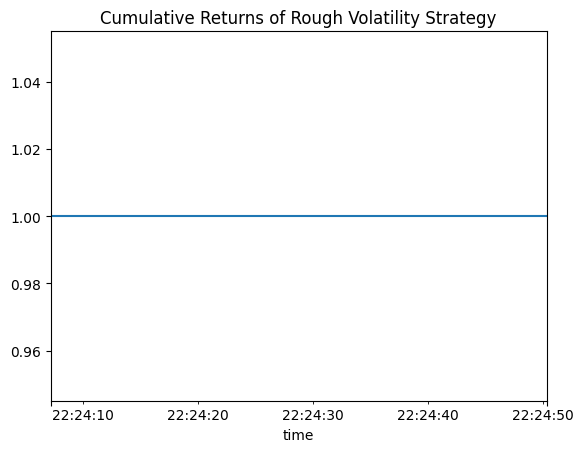

In [9]:
import requests
# Assume 'df' is your DataFrame with 'close', 'volume', and 'time' columns
# Make sure 'time' is set as the index and is in datetime format
# get data for the last 720 candles from kraken api
url = "https://api.kraken.com/0/public/OHLC"
querystring = {"pair": 'SOLUSD',"interval": '1'}
headers = {
'Accept': 'application/json'
}
response = requests.request("GET", url, params=querystring)

# parse the json response and create a dataframe
data = response.json()
df = pd.DataFrame(data['result']['SOLUSD'], columns=['time', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count'])

#besides time and count are strings so we need to convert them to floats
df['close'] = df['close'].astype(float)
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['vwap'] = df['vwap'].astype(float)
df['volume'] = df['volume'].astype(float)
df['count'] = df['count'].astype(float)

df['time'] = pd.to_datetime(df['time'], unit='ms')
df.set_index('time', inplace=True)


strategy = Rough_Vol_Strat(df)
strategy.run_strategy()
strategy.debug_info()  # This will print debugging information

results = strategy.get_results()

# Print the last few rows of the results
print(results.tail())

# Plot the cumulative returns of the strategy
import matplotlib.pyplot as plt
results['cumulative_returns'].plot()
plt.title('Cumulative Returns of Rough Volatility Strategy')
plt.show()